In [1]:
import tensorflow as tf
import pandas as pd
from scipy.spatial.distance import cosine
import numpy as np
from scipy.sparse import csr_matrix
from __future__ import division
import matplotlib.pyplot as plt
from scipy import fft, arange, signal

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_data = pd.read_csv("train_data.csv")

In [3]:
train_data["act"] = train_data["action_id"].apply(lambda x: x[:3])

In [4]:
grp_data = train_data.groupby('act')
grp_data.describe()

attitude.pitch                                                    \
             count      mean       std       min       25%       50%   
act                                                                    
dws       115349.0 -1.146617  0.421438 -1.567578 -1.348902 -1.244252   
jog       118294.0 -1.152384  0.312234 -1.568683 -1.366251 -1.231965   
sit       297235.0 -0.336945  0.229572 -1.527474 -0.450818 -0.340816   
std       263976.0 -1.349868  0.117493 -1.569648 -1.437541 -1.378242   
ups       140250.0 -1.154398  0.409534 -1.569092 -1.393190 -1.256170   
wlk       305399.0 -1.132747  0.343090 -1.569974 -1.336546 -1.189836   

                        attitude.roll            ...  userAcceleration.z  \
          75%       max         count      mean  ...                 75%   
act                                              ...                       
dws -1.102140  1.490554      115349.0  0.116266  ...            0.205185   
jog -1.035885  0.461616      118294.0 -0.151093  ...            0.456403   
sit -0.168665  0.163404      297235.0 -0.239690  ...            0.002692   
std -1.262939 -0.952114      263976.0 -0.450290  ...            0.039693   
ups -1.048627  1.567175      140250.0  0.300432  ...            0.168038   
wlk -1.020010  1.564119      305399.0  0.107096  ...            0.395463   

                user_id                                                   
          max     count       mean       std  min  25%   50%   75%   max  
act                                                                       
dws  4.866772  115349.0  10.985826  6.001622  1.0  6.0  11.0  16.0  21.0  
jog  8.125357  118294.0  10.639424  6.075539  1.0  5.0  10.0  16.0  21.0  
sit  0.876057  297235.0  10.849382  6.116228  1.0  6.0  11.0  16.0  21.0  
std  1.269990  263976.0  11.252512  6.189044  1.0  6.0  11.0  17.0  21.0  
ups  2.482116  140250.0  11.004549  5.947195  1.0  6.0  11.0  16.0  21.0  
wlk  4.352533  305399.0  10.908896  6.044829  1.0  6.0  11.0  16.0  21.0  

[6 rows x 112 columns]

In [5]:
GAN_Input = train_data[(train_data['act']=='ups')]

In [6]:
GAN_Input = GAN_Input.reset_index(drop=True)

In [7]:
input_X = GAN_Input['attitude.pitch']

In [8]:
input_X.size

140250

In [9]:
total_epoch = 10000
batch_size = 100
learning_rate = 0.0001
n_hidden = 256
n_input = 200
n_noise = 128


In [10]:
X = tf.placeholder(tf.float32 , [None , n_input])
Z = tf.placeholder(tf.float32 , [None , n_noise])

In [12]:
g_W1 = tf.Variable(tf.random_normal([n_noise,n_hidden] , stddev=0.001))
g_b1 = tf.Variable(tf.zeros([n_hidden]))
g_W2 = tf.Variable(tf.random_normal([n_hidden,n_input] , stddev=0.001))
g_b2 = tf.Variable(tf.zeros([n_input]))

In [13]:
def generator(noise_z):
    hidden = tf.nn.relu(tf.matmul(noise_z , g_W1) + g_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden , g_W2)+g_b2)
    return output

In [14]:
d_W1 = tf.Variable(tf.random_normal([n_input,n_hidden] , stddev=0.001))
d_b1 = tf.Variable(tf.zeros([n_hidden]))
d_W2 = tf.Variable(tf.random_normal([n_hidden,1] , stddev=0.001))
d_b2 = tf.Variable(tf.zeros([1]))

In [15]:
def discriminator(inputs):
    hidden = tf.nn.relu(tf.matmul(inputs , d_W1) + d_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden , d_W2)+d_b2)
    return output

In [16]:
def get_noise(batch_size , n_noise):
    return np.random.normal(size=(batch_size , n_noise))

In [17]:
G = generator(Z)
D_generate = discriminator(G)
D_real = discriminator(X)

In [18]:
loss_D = tf.reduce_mean(tf.log(D_real))+tf.reduce_mean(tf.log(1-D_generate))

In [19]:
loss_G = tf.reduce_mean(tf.log(D_generate))

In [20]:
d_var_list = [d_W1 , d_b1 , d_W2 , d_b2]
g_var_list = [g_W1 , g_b1 , g_W2 , g_b2]

In [21]:
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D , var_list=d_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G , var_list=g_var_list)

In [22]:
int(GAN_Input['attitude.pitch'].size/(batch_size*n_input))

7

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
total_batch = int(input_X.size/(batch_size*n_input))
loss_val_D , loss_val_G = 0,0

img_contents = dict()

In [24]:
input_X = np.array(input_X[0:n_input*batch_size*total_batch])

In [ ]:
input_X.reshape(n_input,batch_size,total_batch)

In [ ]:
input_X[0:20000].reshape(batch_size,n_input).shape

In [ ]:
x = np
for i in range(total_batch):
    x.append(x,input_X[i*batch_size:(i+1)*batch_size*n_input])

In [ ]:
x.shape()

In [ ]:
tf.train.dataset.batch(list(input_X) , batch_size)

In [25]:
for epoch in range(total_epoch):
    for i in range(total_batch):
#         batch_xs , batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = input_X[i*batch_size*n_input:(i+1)*batch_size*n_input].reshape(batch_size,n_input)
        batch_ys = input_X[i*batch_size*n_input:(i+1)*batch_size*n_input].reshape(batch_size,n_input)
        noise = get_noise(batch_size, n_noise)
        _ , loss_val_D = sess.run([train_D,loss_D],feed_dict={X:batch_xs , Z:noise})
        _ , loss_val_G = sess.run([train_G,loss_G],feed_dict={Z:noise})
#     print('Epoch : {} , D loss : {} , G loss :{}'.format(epoch , loss_val_D , loss_val_G))
    if epoch == 0 or (epoch+1)%1000 ==0:
        sample_size = 10
        noise = get_noise(sample_size , n_noise)
        samples = sess.run(G , feed_dict={Z:noise})
        
        img_contents[epoch] = samples
        print('Epoch : {} , D loss : {} , G loss :{}'.format(epoch , loss_val_D , loss_val_G))

Epoch : 0 , D loss : -1.3715015649795532 , G loss :-0.6986894011497498
Epoch : 999 , D loss : -0.019910713657736778 , G loss :-3.9570932388305664
Epoch : 1999 , D loss : -0.012546062469482422 , G loss :-4.454339504241943
Epoch : 2999 , D loss : -0.003414727048948407 , G loss :-5.841561317443848
Epoch : 3999 , D loss : -0.0012514571426436305 , G loss :-6.986173629760742
Epoch : 4999 , D loss : -0.0009352067136205733 , G loss :-7.258650302886963
Epoch : 5999 , D loss : -0.0014564760494977236 , G loss :-6.704297065734863
Epoch : 6999 , D loss : -0.0009504170157015324 , G loss :-7.093394756317139
Epoch : 7999 , D loss : -0.0007336541311815381 , G loss :-7.361376762390137
Epoch : 8999 , D loss : -0.000871068041305989 , G loss :-7.2003493309021
Epoch : 9999 , D loss : -0.0028624655678868294 , G loss :-5.906983852386475


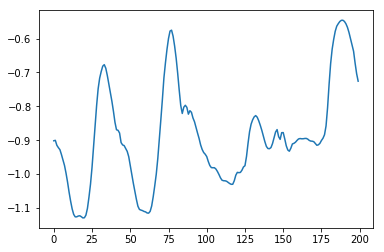

In [28]:
GAN_Input = train_data[(train_data['act']=='ups')]
GAN_Input = GAN_Input.reset_index(drop=True)
input_X = GAN_Input['attitude.pitch']
plt.plot(input_X[0:200])

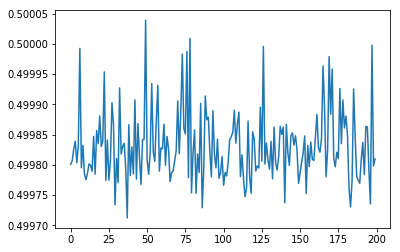

In [30]:
plt.plot(img_contents[0][1]) 

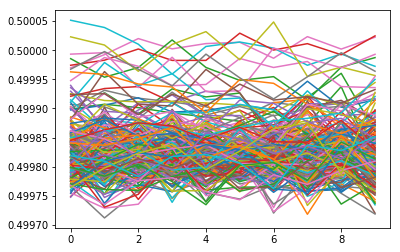

In [31]:
plt.plot(img_contents[0]) 

In [ ]:
img_contents[0][0]

In [ ]:
plt.plot(img_contents[0][0]) 